# Hotel Review Sentiment Analysis Part 2: EDA
## Adura ABIONA, PhD (UNSW)
### 4 May, 2017

## Introduction

This is the **Part 2** of the **Hotel Review Sentiment Analysis** of Australian hotels, from four major cities (Canberra, Sydney, Melbourne and Brisbane), based on reviewers' opionions (on a numerical scale of 1-5) from [**TripAdvisor**](http://www.tripadvisor.com.au) website. This part is focused on **Exploratory Data Analysis (EDA)** of the reviews. 

In [1]:
import glob, os, string
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
matplotlib.style.use('ggplot')
%matplotlib inline 
sep = "~"
DataDir = "Datasets/" 
#nltk.download() # download the english stopwords corpus and the punkt package and maybe the porter stemmer if not present
print(pd.__version__)

0.18.1


#### The block of code below reads the review details for the hotels from the 4 major cities in Australia into a dataframe.

In [2]:
review_feats = ['id', 'title','body','rati','value','locat','sleep','rooms','clean','servi','other']
citys = ['Canberra', 'Sydney', 'Melbourne', 'Brisbane']
review_df = pd.DataFrame() #creates a new dataframe that's empty
for city in citys:
    citydir = os.path.join(os.getcwd(), DataDir + city)
    for file in glob.glob(os.path.join(citydir,"*-review.mcsv")): 
        review_df = review_df.append(pd.read_csv(os.path.join(citydir, file), sep=sep, header=None, names = review_feats), ignore_index=True)

print(review_df.shape)
review_df.head()

(27868, 11)


,id,title,body,rati,value,locat,sleep,rooms,clean,servi,other
0,review_478470647,“Waste of money”,"From the moment we walked into the Adobe,we kn...",1,1,NaN,NaN,2.0,NaN,1.0,NaN
1,review_476951438,“Well appointed room”,On check in was a queue of 6 waiting with only...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,review_476646112,"“Forgotten property ""vanished into thin air"" a...",Review submitted on behalf of my wife who was ...,2,4,NaN,NaN,4.0,NaN,2.0,NaN
3,review_475716850,“Everything you need and more”,This is a great hotel. Clean and really comfor...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_474490948,"“Super handy for shops, food and transport”",This is my go to accommodation in Canberra. Cl...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
review_dfx = review_df[['id', 'title', 'body', 'rati']].copy()
review_dfx['rati'] = pd.to_numeric(review_dfx['rati'], errors='coerce') 
review_dfx = review_dfx.dropna(axis=0)
print(review_dfx.rati.unique())
print(review_dfx.shape)
review_dfx.head()

[ 1.  3.  2.  5.  4.]
(27408, 4)


,id,title,body,rati
0,review_478470647,“Waste of money”,"From the moment we walked into the Adobe,we kn...",1.0
1,review_476951438,“Well appointed room”,On check in was a queue of 6 waiting with only...,3.0
2,review_476646112,"“Forgotten property ""vanished into thin air"" a...",Review submitted on behalf of my wife who was ...,2.0
3,review_475716850,“Everything you need and more”,This is a great hotel. Clean and really comfor...,5.0
4,review_474490948,"“Super handy for shops, food and transport”",This is my go to accommodation in Canberra. Cl...,5.0


### Rating Category Distribution for Reviews
The rating categories (1,2,3,4, and 5) are from now on color coded with red, orange, blue, purple and green respectively.

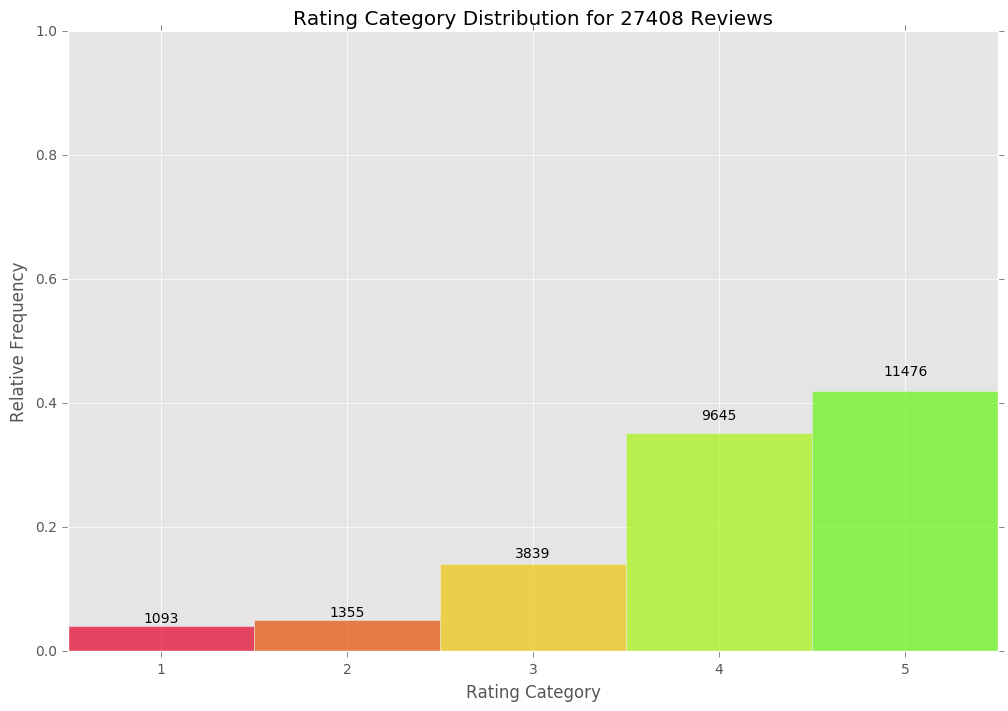

In [4]:
rat_cat = 5
colors = np.array(['#E50029', '#E94E04', '#EEC708', '#A5F30D', '#62F610']) # 1, 2, 3, 4, and 5 ratings respectively

rat_labels = np.array([x_rat+1 for x_rat in range(rat_cat)])
rat_cat_dist_fig = plt.figure(figsize=(12,8))
bar_plot_indices = np.arange(rat_cat)
rat_cat_absolute_freq = review_dfx.rati.value_counts(ascending=True)
rat_cat_relative_freq = np.array(rat_cat_absolute_freq)/float(sum(rat_cat_absolute_freq))

rects = plt.bar(bar_plot_indices, rat_cat_relative_freq, width=1, color=colors, alpha=.7)
for (idx, rect) in enumerate(rects):
        plt.gca().text(rect.get_x()+rect.get_width()/2., 1.05*rect.get_height(), '%d'%int(rat_cat_absolute_freq[idx+1]), ha='center', va='bottom')

plt.xticks(bar_plot_indices+.5, rat_labels)
plt.xlabel('Rating Category')
plt.ylabel('Relative Frequency')
plt.ylim([0,1])
plt.title('Rating Category Distribution for {0} Reviews'.format(len(review_dfx)))

plt.show()

In [5]:
#Some words (e.g. no, not, more, most etc.) have been removed from the standard stopwords available in NLTK. 
#It’s done so because those words can have some sentiment impact in our review dataset.
custom_stopwords = set(stopwords.words('english') + ["n't", "'ve", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS) 
                 + ['hotel', 'room', 'apartment', 'bathroom', 'bedroom', 'bed', 'also'] 
                 + ['canberra', 'sydney', 'melbourne', 'brisbane']) - set(('over', 'under', 'below', 'more', 'most', 'no', 
                                            'not', 'only', 'such', 'few', 'so', 'too', 'very', 'just', 'any', 'once'))
PuncSym = " ".join(string.punctuation).split(" ") + ["-----", "---", "--", "-", "...", "..", "“", "”"]

def preprocess(sentx):
    for ch in string.punctuation:  sentx = sentx.replace(ch, " ") 
    for dg in string.digits:  sentx = sentx.replace(dg, " ") 
    sentx = sentx.strip().replace("\n", " ").replace("\r", " ")
    sentx = sentx.lower()    
    wordList = [word for word in sentx.split() if word not in custom_stopwords] # Given a list of words, remove any that are in a list of stop words.
    sentx = ' '.join(wordList)
    token_list = nltk.word_tokenize(sentx) 
    #STEMMER = PorterStemmer()
    #token_list = [STEMMER.stem(tok) for tok in token_list]
    return token_list

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords=custom_stopwords, background_color=color, width=2500, height=2000).generate(cleaned_word)
    plt.figure(1,figsize=(12, 12))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [6]:
# Given a list of words, return a dictionary of word-frequency pairs.
def wordListToFreqDict(wordlist):
    wordfreq = [wordlist.count(p) for p in wordlist]
    freqdict = dict(zip(wordlist, wordfreq))
    aux = [( freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [7]:
review_dfy5 = review_dfx[review_dfx['rati'] == 5]
print("Rating = 5")
joinStr5 = preprocess(' '.join(review_dfy5['body'].tolist()[:100]))
sorteddict5 = wordListToFreqDict(joinStr5)
itr5 = 0
for s in sorteddict5: 
    print(str(s))
    if itr5 > 4: break 
    itr5 += 1

Rating = 5
(77, 'very')
(66, 'stay')
(58, 'great')
(54, 'good')
(51, 'clean')
(49, 'staff')


Rating = 5


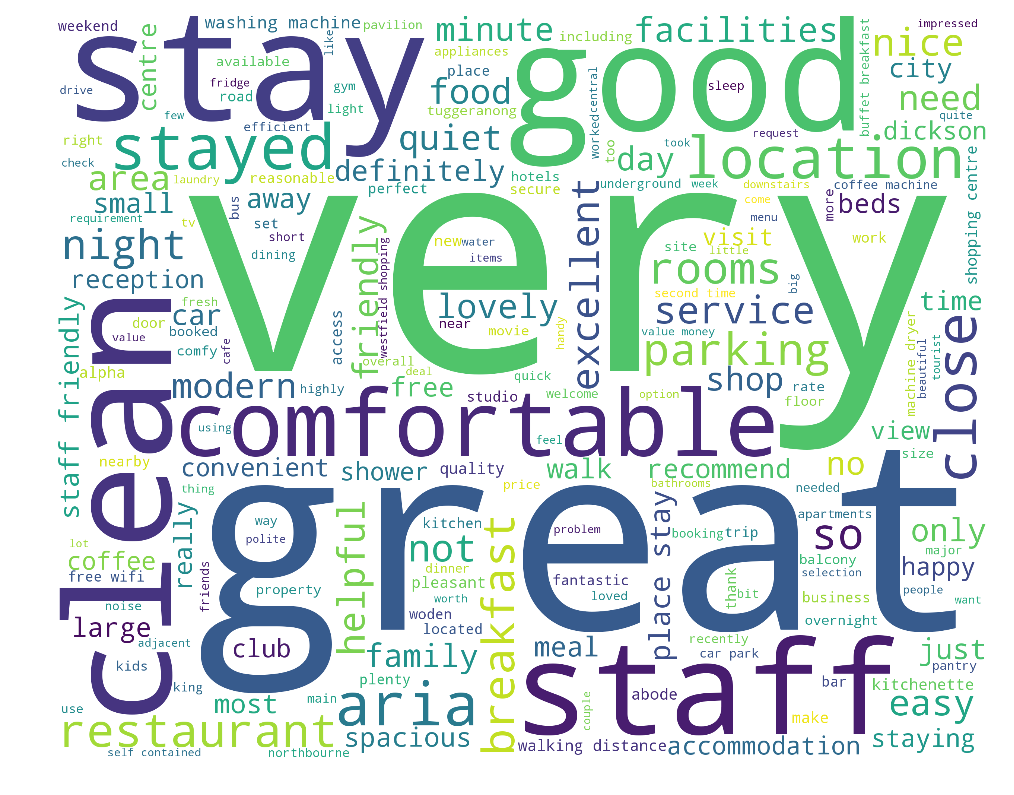

In [8]:
print("Rating = 5")    
wordcloud_draw(joinStr5,'white')

In [9]:
review_dfy3 = review_dfx[review_dfx['rati'] == 3]
print("Rating = 3")
joinStr3 = preprocess(' '.join(review_dfy3['body'].tolist()[:100]))
sorteddict3 = wordListToFreqDict(joinStr3)

itr3 = 0
for s in sorteddict3: 
    print(str(s))
    if itr3 > 4: break 
    itr3 += 1

Rating = 3
(84, 'not')
(80, 'very')
(72, 'no')
(67, 'good')
(54, 'so')
(53, 'staff')


Rating = 3


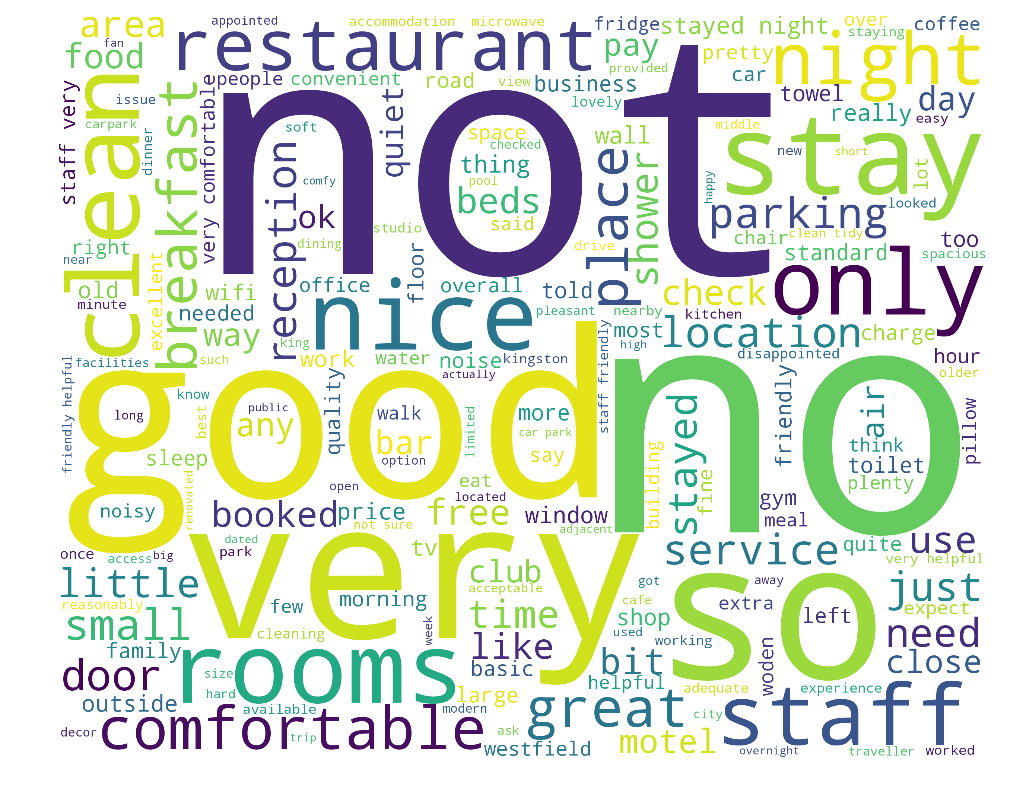

In [10]:
print("Rating = 3")
wordcloud_draw(joinStr3,'white')

In [11]:
review_dfy1 = review_dfx[review_dfx['rati'] == 1]
print("Rating = 1")
joinStr1 = preprocess(' '.join(review_dfy1['body'].tolist()[:100]))
sorteddict1 = wordListToFreqDict(joinStr1)
itr1 = 0
for s in sorteddict1: 
    print(str(s))
    if itr1 > 4: break 
    itr1 += 1

Rating = 1
(164, 'not')
(61, 'stay')
(61, 'so')
(56, 'no')
(56, 'night')
(46, 'staff')


Rating = 1


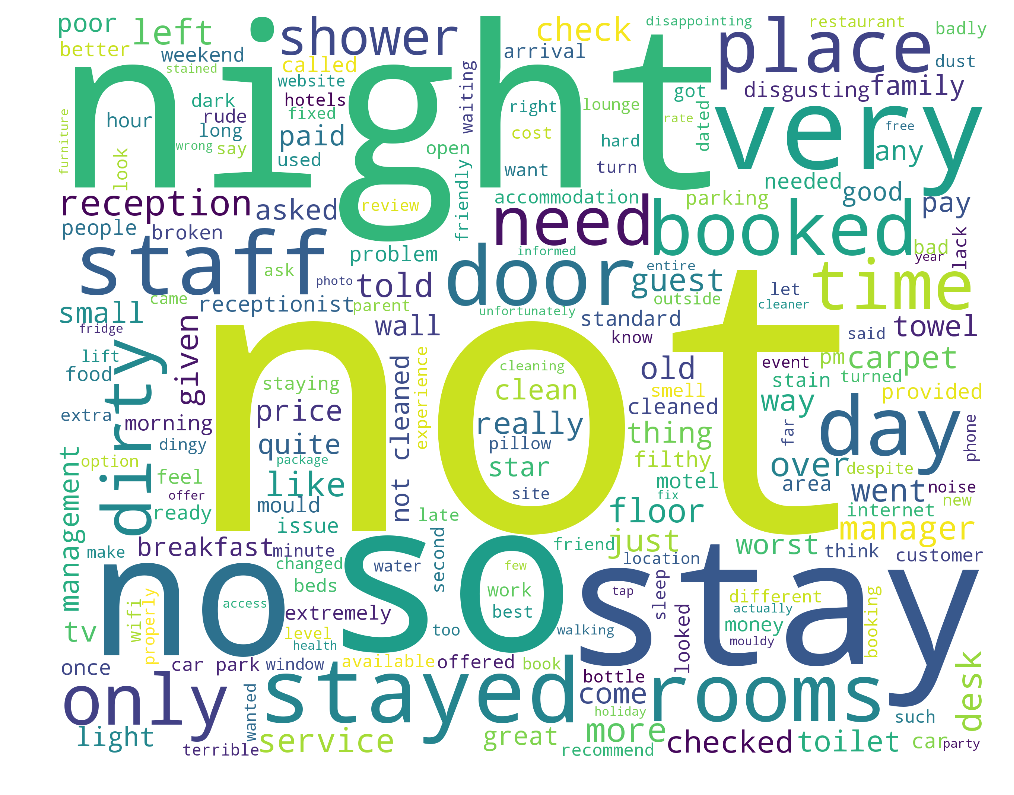

In [12]:
print("Rating = 1")
wordcloud_draw(joinStr1,'white')

## Still in progress ...